*Version 5*<br>
*Last updated: 2021-11-02<p>*
christina.herrick@unh.edu<br>
steeleb@caryinstitute.org<br>
__Please do not distribute__

# **Initial Setup**

This notebook uses the [Google Earth Engine](https://developers.google.com/earth-engine) [Python API](https://developers.google.com/earth-engine/guides/python_install) to extract the surface temperature product from Landsat 4, 5, 7, and 8 Collection 2 images for any water body in the world.


## Modules

This section of code blocks imports necessary python modules for the notebook to run. You will be prompted to click one or more URLs and be taken to a page to sign in with your Google account. This account must already be authorized to use Google Earth Engine. If you do not already have access, [fill out this application](https://signup.earthengine.google.com/#!/).

Copy the unique code(s) provided on the web page when prompted and paste where prompted to finish authorization.

In [312]:
#@markdown __Run this block__ to authorize Colab to authenticate your Google account and give it access to upload files from your local computer ([to be used later](https://colab.research.google.com/drive/1AJFnCB7B7Uev2-0hqIayOb5fkSB0Xn8v#scrollTo=L_Tf54wwIPRy) in the notebook). Once you paste the code, press Enter.
from google.colab import auth, files
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials

In [ ]:
#@markdown __Run this block__ to connect Colab to your Earth Engine account
import ee
ee.Authenticate()
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://accounts.google.com/o/oauth2/auth?client_id=517222506229-vsmmajv00ul0bs7p89v5m89qs8eb9359.apps.googleusercontent.com&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fearthengine+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdevstorage.full_control&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&response_type=code&code_challenge=DGrRNNRc2S_zwkGRzIeGoh1qZCKMaKG8aPTz1aw5Jow&code_challenge_method=S256

The authorization workflow will generate a code, which you should paste in the box below. 
Enter verification code: 4/1AX4XfWj_TiDisWFNTZh8freaYD-rWoA3R_dF4qD2VFmbUV7uIIO-ybIhknI

Successfully saved authorization token.


In [313]:
#@markdown __Run this block__ to connect Colab to your Google Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [314]:
#@markdown __Run this block__ to install packages and functions used for 
#@markdown interactive mapping and data exploration
import pandas as pd
import numpy as np
import os
import re
import matplotlib.pyplot as plt
from time import strftime, sleep
from datetime import datetime, timedelta
import pytz
import folium
from folium import plugins
from google.colab import data_table

# Add custom basemaps to folium
basemaps = {
    'Google Maps': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=m&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Maps',
        overlay = True,
        control = True
    ),
    'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Google Terrain': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=p&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Terrain',
        overlay = True,
        control = True
    ),
    'Google Satellite Hybrid': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    ),
    'Esri Satellite': folium.TileLayer(
        tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
        attr = 'Esri',
        name = 'Esri Satellite',
        overlay = True,
        control = True
    )
}

# Define a method for displaying Earth Engine image tiles on a folium map.
def add_ee_layer(self, ee_object, vis_params, name):
    
    try:    
        # display ee.Image()
        if isinstance(ee_object, ee.image.Image):    
            map_id_dict = ee.Image(ee_object).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.ImageCollection()
        elif isinstance(ee_object, ee.imagecollection.ImageCollection):    
            ee_object_new = ee_object.mosaic()
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
            ).add_to(self)
        # display ee.Geometry()
        elif isinstance(ee_object, ee.geometry.Geometry):    
            folium.GeoJson(
            data = ee_object.getInfo(),
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
        # display ee.FeatureCollection()
        elif isinstance(ee_object, ee.featurecollection.FeatureCollection):  
            ee_object_new = ee.Image().paint(ee_object, 0, 2)
            map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
            folium.raster_layers.TileLayer(
            tiles = map_id_dict['tile_fetcher'].url_format,
            attr = 'Google Earth Engine',
            name = name,
            overlay = True,
            control = True
        ).add_to(self)
    
    except:
        print("Could not display {}".format(name))
    
# Add EE drawing method to folium.
folium.Map.add_ee_layer = add_ee_layer

print("Packages installed")

Packages installed


## Imported variables
These are Landsat-specific variable settings for GEE.

In [ ]:
#@markdown __Run this block__ to import pre-existing features, images, and collections from Earth Engine
wrs2 = ee.FeatureCollection("users/christinaherrickunh/WRS2_descending_2018")
utmbounds = ee.FeatureCollection("users/christinaherrickunh/UTM_Zone_Boundaries")
sw = ee.Image("JRC/GSW1_2/GlobalSurfaceWater")
l4t1 = ee.ImageCollection("LANDSAT/LT04/C02/T1_L2")
l4t2 = ee.ImageCollection("LANDSAT/LT04/C02/T2_L2")
l5t1 = ee.ImageCollection("LANDSAT/LT05/C02/T1_L2")
l5t2 = ee.ImageCollection("LANDSAT/LT05/C02/T2_L2")
l7t1 = ee.ImageCollection("LANDSAT/LE07/C02/T1_L2")
l7t2 = ee.ImageCollection("LANDSAT/LE07/C02/T2_L2")
l8t1 = ee.ImageCollection("LANDSAT/LC08/C02/T1_L2")
l8t2 = ee.ImageCollection("LANDSAT/LC08/C02/T2_L2")

print("variables installed")

variables installed


## Define the lake area

In this section, use either *Option A*, where you define the bounding box, or *Option B* where you import a shape file of your lake. 


###Option A: use a bounding box
If you need help finding your coordinates, try using [OpenStreetMap](https://www.openstreetmap.org/export#map=12/43.3826/-72.0157). The bounding box should be as small as possible while still including the entire lake surface.<p>
Enter coordinates to see a map of the bounding box. You can also click on the map to get interactive pop-ups of the latitude (y) and longitude (x), and replace/re-run the coordinates.

In [ ]:
#@markdown __Run this block__ after inputting your coordinates below.
#@markdown Do not run this block if you are using Option B

#@markdown `lat1` = North
lat1 = '43.4320'  #@param {type:"string"}
#@markdown `lat2` = South
lat2 = '43.3162'  #@param {type:"string"}
#@markdown `lon1` = West
lon1 = '-72.0923'  #@param {type:"string"}
#@markdown `lon2` = East
lon2 = '-72.0154'  #@param {type:"string"}

use_user_input_file = "no"
try:
  lat1 = float(lat1)
  lon1 = float(lon1)
  lat2 = float(lat2)
  lon2 = float(lon2)
except ValueError as e:
  raise ValueError("Coordinates are missing or are not numbers")
box = ee.Geometry.Polygon(
    [[[lon1, lat1], # ur
      [lon2, lat1], # ul
      [lon2, lat2], # ll
      [lon1, lat2]]], None, False) # lr
center_lat = (lat1+lat2)/2
center_lon = (lon1+lon2)/2
locs_map = folium.Map(location=[center_lat,center_lon],zoom_start=10,width=600,height=600)
locs_map.add_child(folium.LatLngPopup())
basemaps['Google Maps'].add_to(locs_map)
locs_map.add_ee_layer(box,{},'aoi')
display(locs_map)

###Option B: upload a table file
Using your Google Earth Engine account, upload a shapefile or csv of your study lake to your Assets and link to it here.<p>Click [here](https://drive.google.com/file/d/1lfFoZzQD_wAA7Bnil7mI4zwjKDG5kegh/view?usp=sharing) and [here](https://drive.google.com/file/d/1KNaZV63J_LUp6X1OcoLX1wonF0ASiIzi/view?usp=sharing) for screenshots of the process. 

In [ ]:
#@markdown File path should begin with 'users/'
user_input_file = "" #@param {type: "string"}
use_user_input_file = "no" #@param ["yes","no"] {allow-input: false}
#@markdown Remember to __run this block__ after filling in the above fields.
#@markdown Do not run this block if you are using Option A.

In [ ]:
#@markdown For Opt B, __run this block__ to calculate the centroid latitude and longitude
if len(user_input_file)>1:
  shp = ee.FeatureCollection(user_input_file).geometry()
  centroid = shp.centroid(10).getInfo()["coordinates"]
  center_lat = centroid[1]
  center_lon = centroid[0]
  print(center_lat)
  print(center_lon)
else:
  print("No file input; will use Opt A bounding box coordinates")

No file input; will use Opt A bounding box coordinates


In [ ]:
#@markdown For Opt B, __run this block__ to confirm the waterbody AOI
if 'shp' in globals() or 'shp' in locals():
  shp_map = folium.Map(location=[center_lat,center_lon],zoom_start=10,width=600,height=600)
  shp_map.add_child(folium.LatLngPopup())
  basemaps['Google Maps'].add_to(shp_map)
  shp_map.add_ee_layer(shp,{},'aoi')
  display(shp_map)
else:
  print("Display does not apply here; Opt A bounding box is being used for AOI")

Display does not apply here; Opt A bounding box is being used for AOI


## Set remaining user variables

This section defines acceptable water persistence and error for the Landsat pixels, the time period of interest, and confirms the path and row for Landsat acquisition. You can also change the default Google Drive folder for any outputs.

In [ ]:
#@markdown The default path for any exports is in the Colab Notebooks directory 
#@markdown within Google Drive. If preferred, it can be changed here
output_dir = "/content/drive/MyDrive/NASA Landsat Temperature Product/Colab Output/C2" #@param {type:"string"}
#@markdown Enter a file naming prefix for any exports (no spaces or special characters)
file_prefix = "C2" #@param {type:"string"}

if not os.path.exists(output_dir):
  os.makedirs(output_dir)

#forTableExport = output_dir.split("/content/drive/MyDrive/")
#if not len(forTableExport)<2: #if the pass seems valid
#  short_dir = ''.join(forTableExport[1::])
#else:
#  short_dir = 'Colab Notebooks'


slash_loc = output_dir.replace('/', '_')
slash_loc = slash_loc.rfind('_')
short_dir = output_dir[slash_loc+1:]
#print('here',short_dir)

def check_splcharacter(test):
  string_check = re.compile('[@!#$%^&*() <>?/\|}{~:]')
  if not string_check.search(test)==None:
    print("Your file prefix contains special characters, please fix")
    file_prefix = "your_lake_name"
  else:
    print("File prefix:",test)

check_splcharacter(file_prefix)

File prefix: C2


In [ ]:
#@markdown Boundaries of water bodies are automatically detected using the JRC 
#@markdown Global Surface Water Mapping Layer dataset of percent water occurrence. 
#@markdown By default, a pixel has to be classified as water at least 55% of the 
#@markdown time. This is defined as `pctTime`

#@markdown <p>More information on this dataset can be found at https://doi.org/10.1038/nature20584

pctTime = 55  #@param {type: "number"}
#@markdown __Run this block__ after inputting the above parameter

In [ ]:
#@markdown Landsat scenes from both Tier 1 and Tier 2 of Collection 1 are 
#@markdown included for possible use. From Tier 2, only scenes that are processed 
#@markdown to L1T with a combined RMS error of no greater than 30 meters are 
#@markdown considered.
rmse = 24  #@param {type: "number"}
#@markdown __Run this block__ after inputting the above parameter

In [ ]:
#@markdown Landsat records begin in 1984 with Landsat 4 TM. 
#@markdown Enter the year range that you want to search, as well as months of 
#@markdown the year. To search all months, `m1 = 1` and `m2 = 12` <p>
#@markdown <p>First year (y1) and last year (y2). Years are inclusive.<p>
#@markdown <p>First month (m1) and last month (m2). Months are inclusive.<p>
#@markdown <p>Note that this method has only been developed for lake ice-off temperature estimation. 

y1 = 1980 #@param {type: "number"}
y2 = 2020 #@param {type: "number"}

m1 = 5 #@param {type: "number"}
m2 =  11#@param {type: "number"}
print('Script will search years %d through %d and months %d through %d of each year' % (y1,y2,m1,m2))
#@markdown __Run this block__ after inputting the above parameters

Script will search years 1980 through 2020 and months 5 through 11 of each year


In [ ]:
#@markdown __Run this block__ to calculate the Landsat path(s) and row(s) that 
#@markdown overlap the extent of Option A/B It will print as
#@markdown `WRS2 Path/Row: PPPRRR` where `PPP` is the three-digit path, and 
#@markdown `RRR` is the three-digit row.

if use_user_input_file=="yes":
  try:
    box = shp
  except NameError:
    raise NameError("Cannot find user-input file. Are you using Option B or Opt A bounding box? You may need to correct and rerun.")

pathrow = wrs2.filterBounds(box)
  
num_of_pr = len(pathrow.getInfo()["features"])
path_west = 1
path_east = 233
row_north = 122
row_south = 1

for i in range(0,num_of_pr):
  pr = pathrow.getInfo()["features"][i]["properties"]["PR"]
  p = pr[:3]
  r = pr[3:]
  if int(p) > path_west:
    path_west = int(p)
  if int(p) < path_east:
    path_east = int(p)
  if int(r) < row_north:
    row_north = int(r)
  if int(r) > row_south:
    row_south = int(r)

print('Google Earth Engine settings:')
p1 = path_west
p2 =  path_east
r1 =  row_north
r2 =  row_south
print(f'\nbounding paths: {path_west} to {path_east}')
print(f'bounding rows: {row_north} to {row_south}')

utm = utmbounds.filterBounds(box)

#indicate UTM zone
if not len(utm.getInfo()["features"])>1:
  printUTM = utm.getInfo()["features"][0]["properties"]["ZONE"]
  printNS = utm.getInfo()["features"][0]["properties"]["HEMISPHERE"]
  print("UTM Zone:",printUTM,printNS)
else:
  print(utm.getInfo()["features"][1]["properties"]["ZONE"],"(AOI overlaps two UTM zones)")
  print(printUTM,"will be used for projected CRS")
  printNS = utm.getInfo()["features"][1]["properties"]["HEMISPHERE"]

#indicate hemisphere  
if printNS == 'n':
  crs_out = f"EPSG:326{printUTM}"
else:
  crs_out = f"EPSG:327{printUTM}"
print("CRS:",crs_out)


Google Earth Engine settings:

bounding paths: 13 to 13
bounding rows: 30 to 30
UTM Zone: 18 n
CRS: EPSG:32618


In [ ]:
#@markdown __Run this block__ to confirm path and row overlap with your lake. Your lake will be highlighted in a blue box.
zone_map = folium.Map(location=[center_lat,center_lon],zoom_start=8,width=600,height=600)
zone_map.add_child(folium.LatLngPopup())
basemaps['Google Maps'].add_to(zone_map)
zone_map.add_ee_layer(pathrow,{},'path row')
zone_map.add_ee_layer(box,{},'aoi box')
display(zone_map)

# **Find water pixels & delineate boundary**
This step uses the bounding box or the table file as well as the water persistence using [JRC Water dataset](https://global-surface-water.appspot.com/) to define the waterbody area. 

Note, in some cases the _Opt A_ bounding box method will include upstream and downstream water areas, particularily where there are rivers that are large enough to be detected by Landsat. To avoid this, use the _Opt B_ table file method. <p>
You can explore the JRC Water dataset [here](https://global-surface-water.appspot.com/).<p>

In [ ]:
#@markdown This code block reduces the bounding box defined above to the largest water body present, and then counts the 30m pixels within the water body.<p>
#@markdown Landsat scenes included in analysis must have a minimum percentage of clear lake pixels available (these are discontinuous pixels)
pctLakeCoverage = 25 #@param
#@markdown __Run this block__ after inputting the above parameter

wateroccurrence = sw.select(0).setDefaultProjection(crs_out);
water = wateroccurrence.gte(pctTime)
water = water.updateMask(water.neq(0))

def addArea(feature):
  # returns area +/- 1sqm
  return feature.set({'area':feature.geometry().area(1)})  

regions = water.addBands(wateroccurrence).reduceToVectors(
    reducer=ee.Reducer.min(),
    geometry=box,
    scale=30,
    maxPixels=5e9,
    geometryInNativeProjection=False,
    labelProperty='surfaceWater').map(addArea).sort('area',False);

lake_outline = ee.Feature(regions.first())
aoi = lake_outline
geo = lake_outline.geometry()
coords = geo.getInfo()['coordinates'][0]

watercount = water.reduceRegion(reducer=ee.Reducer.count().unweighted(), 
                                geometry=lake_outline.geometry(),
                                scale=30, bestEffort=True)
totalpixels = watercount.getInfo()["occurrence"]
pixel_min = totalpixels*(pctLakeCoverage/100.0)
print("\n\nTotal # of lake pixels: ", totalpixels);
print(f"{pctLakeCoverage}% of available lake pixels is", int(pixel_min))

pixel_map = folium.Map(location=[center_lat,center_lon],zoom_start=10, width=600, height=600)
basemaps['Google Satellite'].add_to(pixel_map)
pixel_map.add_ee_layer(geo,{},'pixels over lake')
display(pixel_map)



Total # of lake pixels:  17165
25% of available lake pixels is 4291


# **Get Skin Surface Temperatures**
Using all of the information amassed so far, the code blocks in this section perform all necessary steps to get skin temperature.

In [ ]:
# @title Landsat functions
# @markdown __Run this block__ to define the functions that pre-process
# @markdown Landsat images.
def prep457bands(img):
  systime = img.get('system:time_start')
  elev = img.get("SUN_ELEVATION")
  sza = ee.Number(90).subtract(elev)
  
  qa = img.select(["QA_PIXEL"])
  cloud1 = qa.bitwiseAnd(2).eq(0)  # bit 1, dilated cloud
  cloud3 = qa.bitwiseAnd(8).eq(0)  # bit 3, cloud
  snow = qa.bitwiseAnd(32).eq(0)  # bit 5, snow
  cloud_confid = qa.rightShift(8).bitwiseAnd(3).lt(2)  # bits 8-9
  snow_confid = qa.rightShift(12).bitwiseAnd(3).lt(2)  # bits 12-13
  cirrus_confid = qa.rightShift(14).bitwiseAnd(3).lt(2)  # bits 14-15

  temp = img.select(["ST_B6"],["surface_temp"]).multiply(0.00341802).add(149).add(-273.15)
  
  updated = (temp.updateMask(cloud1).updateMask(cloud3).updateMask(snow)
  .updateMask(cloud_confid).updateMask(snow_confid).updateMask(cirrus_confid))
          
  return ee.Image(updated).copyProperties(img).set("system:time_start",systime).set("SOLAR_ZENITH_ANGLE", sza)

def prep8bands(img):
  systime = img.get('system:time_start')
  elev = img.get("SUN_ELEVATION")
  sza = ee.Number(90).subtract(elev)

  qa = img.select(["QA_PIXEL"])
  cloud1 = qa.bitwiseAnd(2).eq(0)  # bit 1, dilated cloud
  cloud2 = qa.bitwiseAnd(4).eq(0)  # bit 2, cirrus (high confidence)
  cloud3 = qa.bitwiseAnd(8).eq(0)  # bit 3, cloud
  snow = qa.bitwiseAnd(32).eq(0)  # bit 5, snow
  cloud_confid = qa.rightShift(8).bitwiseAnd(3).lt(2)  # bits 8-9
  snow_confid = qa.rightShift(12).bitwiseAnd(3).lt(2)  # bits 12-13
  cirrus_confid = qa.rightShift(14).bitwiseAnd(3).lt(2)  # bits 14-15
  
  temp = img.select(["ST_B10"],["surface_temp"]).multiply(0.00341802).add(149).add(-273.15)
  updated = (temp.updateMask(cloud1).updateMask(cloud3).updateMask(snow).
             updateMask(cloud_confid).updateMask(snow_confid).updateMask(cirrus_confid))

  return ee.Image(updated).copyProperties(img).set("system:time_start",systime).set("SOLAR_ZENITH_ANGLE", sza)


print("Functions imported", strftime("%x %X"))

Functions imported 11/04/21 12:53:32


In [ ]:
# @title Filter and Stack Landsat

# @markdown __Run this block__ to filter by date and site location, 
# @markdown then convert temperature from K --> C, stack them together, and make 
# @markdown sure the metadata and system time carries over. For landsat 8, make 
# @markdown sure scenes are nadir and the TIRS algorithm isn't preliminary version.

# @markdown Filter by solar zenith angle? This is useful in high-latitude areas
filter_sza = "yes" #@param ["yes","no"] {allow-input: false}

l4 = (l4t1.merge(l4t2).filterMetadata('L1_PROCESSING_LEVEL','equals','L1TP') \
      .filterMetadata('GEOMETRIC_RMSE_MODEL','not_greater_than',rmse) \
      .filterBounds(geo) \
      .filter(ee.Filter.calendarRange(y1,y2,'year')) \
      .filter(ee.Filter.calendarRange(m1,m2,'month')) \
      .filterMetadata('WRS_ROW','not_less_than',r1).filterMetadata('WRS_ROW','not_greater_than',r2) \
      .filterMetadata('WRS_PATH','not_greater_than',p1).filterMetadata('WRS_PATH','not_less_than',p2) \
      .map(prep457bands, True))

l5 = (l5t1.merge(l5t2).filterMetadata('L1_PROCESSING_LEVEL','equals','L1TP') \
      .filterMetadata('GEOMETRIC_RMSE_MODEL','not_greater_than',rmse) \
      .filterBounds(geo) \
      .filter(ee.Filter.calendarRange(y1,y2,'year')) \
      .filter(ee.Filter.calendarRange(m1,m2,'month')) \
      .filterMetadata('WRS_ROW','not_less_than',r1).filterMetadata('WRS_ROW','not_greater_than',r2) \
      .filterMetadata('WRS_PATH','not_greater_than',p1).filterMetadata('WRS_PATH','not_less_than',p2) \
      .map(prep457bands, True))

l7 = (l7t1.merge(l7t2).filterMetadata('L1_PROCESSING_LEVEL','equals','L1TP') \
      .filterMetadata('GEOMETRIC_RMSE_MODEL','not_greater_than',rmse) \
      .filterBounds(geo) \
      .filter(ee.Filter.calendarRange(y1,y2,'year')) \
      .filter(ee.Filter.calendarRange(m1,m2,'month')) \
      .filterMetadata('WRS_ROW','not_less_than',r1).filterMetadata('WRS_ROW','not_greater_than',r2) \
      .filterMetadata('WRS_PATH','not_greater_than',p1).filterMetadata('WRS_PATH','not_less_than',p2) \
      .map(prep457bands, True))

l8 = (l8t1.merge(l8t2).filterMetadata('NADIR_OFFNADIR','equals','NADIR') \
      .filterMetadata('TIRS_SSM_MODEL','not_equals','PRELIMINARY') \
      .filterMetadata('L1_PROCESSING_LEVEL','equals','L1TP') \
      .filterMetadata('GEOMETRIC_RMSE_MODEL','not_greater_than',rmse) \
      .filterBounds(geo) \
      .filter(ee.Filter.calendarRange(y1,y2,'year')) \
      .filter(ee.Filter.calendarRange(m1,m2,'month')) \
      .filterMetadata('WRS_ROW','not_less_than',r1).filterMetadata('WRS_ROW','not_greater_than',r2) \
      .filterMetadata('WRS_PATH','not_greater_than',p1).filterMetadata('WRS_PATH','not_less_than',p2) \
      .map(prep8bands, True))

if filter_sza=="yes":
  landsat = ee.ImageCollection((l4).merge(l5).merge(l7).merge(l8)).filterMetadata('SOLAR_ZENITH_ANGLE','less_than',77).sort('system:time_start')
else:
  landsat = ee.ImageCollection((l4).merge(l5).merge(l7).merge(l8)).sort('system:time_start')

print("Landsat compiled at", strftime("%x %X"))

'''
Add metadata to each scene that indicates how many visible pixels were included 
in analysis, and filter images so that only scenes with the minimum number of 
pixels remain.
'''
def countPixels(img):
  img = ee.Image(img)
  getCount = img.reduceRegion(**{
      "reducer": ee.Reducer.count(),
      "geometry": geo, 
      "scale": 30})
  count = ee.Dictionary(getCount).get('surface_temp')
  return img.set('pixel_count',count)
before = landsat.map(countPixels)
countedPixels = before.filterMetadata('pixel_count','not_less_than', pixel_min)
print('Total number of LS scenes:',len(before.getInfo()['features']),'\nNumber of LS scenes after filter:', len(countedPixels.getInfo()['features']))
print("Landsat filtered:", strftime("%x %X"))

Landsat compiled at 11/04/21 12:53:32
Total number of LS scenes: 603 
Number of LS scenes after filter: 350
Landsat filtered: 11/04/21 12:54:00


# **Data Visualization**
The code blocks in the following section allow you to explore your results using dataframes and pixel-value distributions. You can visually inspect each scene for errant data or export the data to explore further.

In [ ]:
#@title Convert data from server-side EE objects to client-side Python objects
#@markdown __Run this block__ to define functions for data exploration

def generate_histogram(img):
  img = ee.Image(img)
  fhisto = img.reduceRegion(**{
      "reducer": ee.Reducer.fixedHistogram(-5,30,350).unweighted(),
      "geometry": geo,
      "scale": 30,
      "maxPixels": 5e9
  })
  return img.set('histogram',fhisto.get('surface_temp'))
print("Will generate histograms with a fixed x-axis between -5 - 30 deg C in 0.1 degree bins")

# These functions convert image pixels to numpy arrays
def createArrays(img):
  psi_prop = ee.Image(img).sampleRectangle(region=geo, defaultValue=-1)
  getProp = psi_prop.get("surface_temp")
  return img.set("img_array", getProp)

def getArrays(client_img_col):
  list_of_arrays = []
  for img in client_img_col:
    prop = img["properties"]["img_array"]
    a = np.array(prop)
    list_of_arrays.append(a)
  return list_of_arrays

Will generate histograms with a fixed x-axis between -5 - 30 deg C in 1 degree bins


In [ ]:
# @markdown This code block executes the functions from the previous block and 
# @markdown converts the image collection from a server-side EE object to a client-side 
# @markdown Python object. This allows iteration over the image collection with a `for` 
# @markdown loop, which provides much more Python functionality.<p><mark>__This step 
# @markdown could take some time to run</mark> depending on the length of the 
# @markdown ImageCollection.__
print("Start:", strftime("%x %X"))
imgs_histo = countedPixels.map(generate_histogram)
generate_arrays = imgs_histo.map(createArrays)

imgCol = generate_arrays.getInfo()["features"]
print("Finish:", strftime("%x %X"))
print("Number of Landsat scenes: ", len(imgCol))

Start: 10/21/21 18:46:27
Finish: 10/21/21 18:48:12
Number of Landsat scenes:  350


In [ ]:
#@markdown Now that the image collection is client-side, __run this block__ to 
#@markdown get arrays of each image.
# returns a list of arrays
imgs_to_arrays = getArrays(imgCol)
print("Converted images to arrays")

Converted images to arrays


In [ ]:
#@title View and export collated pixel distributions
#@markdown __Run this block__ to iterate through the image collection and convert 
#@markdown all bins and frequencies to a single Pandas `DataFrame`. 
#@markdown This returns *bins* (in deg C) in the first column, the image date as 
#@markdown all subsequent column headers, and the pixel counts within each bin.

length_plots = len(imgCol)
list_of_dfs = []
list_of_uids = []
# fig = make_subplots(rows=length_plots, cols=1)
for i in imgCol:
  uid = (i['properties']['L1_LANDSAT_PRODUCT_ID'])
  list_of_uids.append(uid)
  histogram = i["properties"].get("histogram")

  a = pd.DataFrame(histogram, columns=["bin",uid]).set_index("bin")
  # fig.add_histogram()
  list_of_dfs.append(a)

appended_dfs = pd.concat(list_of_dfs,ignore_index=False, axis=1)
transposed_dfs = appended_dfs.T
data_table.DataTable(appended_dfs, include_index=True, max_columns=50, max_rows=50, num_rows_per_page=50)

,LT05_L1TP_013030_19840610_20200918_02_T1,LT05_L1TP_013030_19840930_20200918_02_T1,LT05_L1TP_013030_19841016_20200918_02_T1,LT05_L1TP_013030_19850901_20200918_02_T1,LT05_L1TP_013030_19850917_20200918_02_T1,LT05_L1TP_013030_19851120_20200918_02_T1,LT05_L1TP_013030_19860515_20200917_02_T1,LT05_L1TP_013030_19860616_20200917_02_T1,LT05_L1TP_013030_19860718_20200917_02_T1,LT05_L1TP_013030_19861022_20200917_02_T1,LT05_L1TP_013030_19861123_20200917_02_T1,LT05_L1TP_013030_19870502_20201014_02_T1,LT04_L1TP_013030_19870526_20201014_02_T1,LT05_L1TP_013030_19870619_20201014_02_T1,LT05_L1TP_013030_19870806_20201014_02_T1,LT05_L1TP_013030_19871009_20201014_02_T1,LT05_L1TP_013030_19871025_20201014_02_T1,LT05_L1TP_013030_19880605_20200917_02_T1,LT05_L1TP_013030_19880621_20200917_02_T1,LT05_L1TP_013030_19880707_20200917_02_T1,LT05_L1TP_013030_19880723_20200917_02_T1,LT05_L1TP_013030_19880808_20200917_02_T1,LT05_L1TP_013030_19880909_20200917_02_T1,LT05_L1TP_013030_19880925_20200917_02_T1,LT05_L1TP_013030_19881027_20200917_02_T1,LT05_L1TP_013030_19881112_20200917_02_T1,LT05_L1TP_013030_19890507_20200916_02_T1,LT05_L1TP_013030_19890726_20200916_02_T1,LT04_L1TP_013030_19890803_20200916_02_T1,LT04_L1TP_013030_19890819_20200916_02_T1,LT05_L1TP_013030_19890827_20200916_02_T1,LT05_L1TP_013030_19890928_20200916_02_T1,LT05_L1TP_013030_19891014_20200916_02_T1,LT05_L1TP_013030_19891030_20200916_02_T1,LT05_L1TP_013030_19900526_20200916_02_T1,LT05_L1TP_013030_19900627_20200915_02_T1,LT04_L1TP_013030_19900721_20200915_02_T1,LT05_L1TP_013030_19900729_20200916_02_T1,LT05_L1TP_013030_19900830_20200916_02_T1,LT05_L1TP_013030_19901001_20200915_02_T1,...,LE07_L1TP_013030_20171104_20200830_02_T1,LC08_L1TP_013030_20171112_20200902_02_T1,LC08_L1TP_013030_20171128_20200902_02_T1,LC08_L1TP_013030_20180523_20200901_02_T1,LE07_L1TP_013030_20180531_20200829_02_T1,LE07_L1TP_013030_20180702_20200829_02_T1,LC08_L1TP_013030_20180710_20200831_02_T1,LE07_L1TP_013030_20180718_20200829_02_T1,LE07_L1TP_013030_20180819_20200829_02_T1,LC08_L1TP_013030_20180827_20200831_02_T1,LE07_L1TP_013030_20180904_20200828_02_T1,LC08_L1TP_013030_20181014_20200830_02_T1,LE07_L1TP_013030_20181022_20200827_02_T1,LE07_L1TP_013030_20181107_20200827_02_T1,LE07_L1TP_013030_20190518_20200825_02_T1,LC08_L1TP_013030_20190526_20200828_02_T1,LE07_L1TP_013030_20190603_20200825_02_T1,LC08_L1TP_013030_20190627_20200827_02_T1,LE07_L1TP_013030_20190705_20200825_02_T1,LC08_L1TP_013030_20190713_20200827_02_T1,LC08_L1TP_013030_20190729_20200827_02_T1,LE07_L1TP_013030_20190806_20200824_02_T1,LC08_L1TP_013030_20190814_20200827_02_T1,LE07_L1TP_013030_20190822_20200824_02_T1,LC08_L1TP_013030_20190830_20200826_02_T1,LE07_L1TP_013030_20190907_20200824_02_T1,LC08_L1TP_013030_20190915_20200826_02_T1,LE07_L1TP_013030_20191009_20200823_02_T1,LC08_L1TP_013030_20191102_20200825_02_T1,LE07_L1TP_013030_20191126_20200823_02_T1,LE07_L1TP_013030_20200520_20200820_02_T1,LE07_L1TP_013030_20200621_20200822_02_T1,LC08_L1TP_013030_20200715_20200912_02_T1,LC08_L1TP_013030_20200731_20200908_02_T1,LE07_L1TP_013030_20200824_20200920_02_T1,LE07_L1TP_013030_20200909_20201005_02_T1,LC08_L1TP_013030_20200917_20201005_02_T1,LE07_L1TP_013030_20200925_20201021_02_T1,LC08_L1TP_013030_20201003_20201015_02_T1,LE07_L1TP_013030_20201011_20201107_02_T1
bin,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-5.0,0,0,0,0,0,0,0,0,0,0,10,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-4.9,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-4.8,0,0,0,0,0,0,0,0,0,0,151,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
-4.7,0,0,0,0,0,0,0,0,0,0,205,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [ ]:
#@markdown __Run this block__ to export the `DataFrame` as a csv to your Google Drive

if not 'output_dir' in globals():
  output_dir = "drive/My Drive/Colab Notebooks/"
out_histo_compiled = os.path.join(output_dir, file_prefix + "_histograms.csv")
appended_dfs.to_csv(out_histo_compiled)
print("Export completed:", out_histo_compiled)

Export completed: /content/drive/MyDrive/NASA Landsat Temperature Product/Colab Output/C2/C2_histograms.csv


350  histograms will be generated
Start: 10/21/21 18:48:55
Finish: 10/21/21 18:50:34 
To Save your histograms, right click and select *Save Image As*


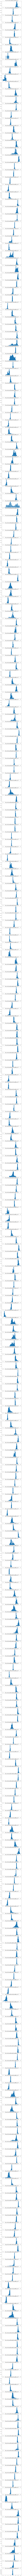

In [ ]:
#@title View pixel distribution using `matplotlib`
#@markdown __Run this block__ to generate histogram charts of lake temperature 
#@markdown for each Landsat scene as a png that exports to your specified output directory. This step can also take some time to run.
print(len(list_of_uids)," histograms will be generated")
print("Start:", strftime("%x %X"))
figure, axis = plt.subplots(len(list_of_uids),1, 
                            figsize=(8,3*len(list_of_uids)),
                            frameon=False, 
                            dpi=50)
x = appended_dfs.index

for row in range(0,len(list_of_uids)):
  uid = list_of_uids[row]
  y = appended_dfs[uid]
  axis[row].bar(x,y)
  axis[row].set_title(uid)
print("Finish:", strftime("%x %X"), '\nTo Save your histograms, right click and select *Save Image As*')

#Export to CSV

In [ ]:
#@markdown Execute this cell block to export a CSV containing temperature and related image metadata

def exportWholeLakeStats(img):
  img = ee.Image(img).clip(geo)

  # retrieve image metadata for output file
  landsattime = img.get('system:time_start')
  cloudcover = img.get('CLOUD_COVER')
  esd = img.get("EARTH_SUN_DISTANCE")
  elev = img.get('SUN_ELEVATION')
  azi = img.get('SUN_AZIMUTH')
  sza = img.get('SOLAR_ZENITH_ANGLE')
  count = img.get('pixel_count')
  pctAvail = ee.Number(count).divide(totalpixels)
  #flags = ee.List([])

  # get statistics for skin_temperature
  reducers = ee.Reducer.mean().combine(**{
      "reducer2": ee.Reducer.stdDev(), "sharedInputs":True}).combine(**{
      "reducer2": ee.Reducer.minMax(), "sharedInputs":True}).combine(**{
      "reducer2": ee.Reducer.median(**{"maxBuckets":500, "minBucketWidth": 0.125}), "sharedInputs":True}).combine(**{
      "reducer2": ee.Reducer.skew(), "sharedInputs":True}).combine(**{
      "reducer2": ee.Reducer.percentile(**{"percentiles": [25,75], "maxBuckets": 500, "minBucketWidth": 0.125}), "sharedInputs":True}).combine(**{
      "reducer2": ee.Reducer.count(), "sharedInputs":True})
  
  stats = img.reduceRegion(**{
      "reducer": reducers,
      "geometry": geo,
      "scale": 30,
      "maxPixels": 5e9
  })
  
  more_stats = ee.Dictionary({'pixel_count':count,
                            'landsat_time':landsattime,
                            'cloud_cover':cloudcover,
                            'elev':elev,
                            'azimuth':azi,
                            'esd':esd,
                            'sza':sza,
                            'pct_lake':pctAvail,
                            'l_exceltime':ee.Number(landsattime).divide(1000.0).divide(86400).add(25569)
                            })
  stats2 = ee.Dictionary.combine(stats, more_stats)

  return ee.Feature(None,stats2)

temp_stats = countedPixels.map(exportWholeLakeStats)

#create the file name with user-specified prefix
temp_filename = (file_prefix+'_temp_stats')

export_task = ee.batch.Export.table.toDrive(**{
    'collection': temp_stats,
    'description': temp_filename,
    "fileFormat": "CSV",
    'folder': short_dir
})

print("Exporting ", temp_filename+".csv")
export_task.start()
print('Polling for task (id: {}) at'.format(export_task.id))

while export_task.active():
  print(strftime("%x %X"), export_task.status())
  sleep(10)

print("Finished:", strftime("%x %X"))

print('Export should now be visible in Drive at path:\n',short_dir)

Exporting  C2_temp_stats.csv
Polling for task (id: QKPTLLBHKYCH67SVJPPLFOGS) at
11/04/21 13:18:39 {'state': 'READY', 'description': 'C2_temp_stats', 'creation_timestamp_ms': 1636031919127, 'update_timestamp_ms': 1636031919127, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_FEATURES', 'id': 'QKPTLLBHKYCH67SVJPPLFOGS', 'name': 'projects/earthengine-legacy/operations/QKPTLLBHKYCH67SVJPPLFOGS'}
11/04/21 13:18:50 {'state': 'READY', 'description': 'C2_temp_stats', 'creation_timestamp_ms': 1636031919127, 'update_timestamp_ms': 1636031919127, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_FEATURES', 'id': 'QKPTLLBHKYCH67SVJPPLFOGS', 'name': 'projects/earthengine-legacy/operations/QKPTLLBHKYCH67SVJPPLFOGS'}
11/04/21 13:19:00 {'state': 'READY', 'description': 'C2_temp_stats', 'creation_timestamp_ms': 1636031919127, 'update_timestamp_ms': 1636031919127, 'start_timestamp_ms': 0, 'task_type': 'EXPORT_FEATURES', 'id': 'QKPTLLBHKYCH67SVJPPLFOGS', 'name': 'projects/earthengine-legacy/operations/QKPTLLBH

# **Pair Landsat with *in-situ* data**
This next section is optional, but allows you to compare any field data you may have to the Landsat data produced here. This section uses the CSV exported above<p>
In order for this to run successfully, your data must be in CSV format and have the following headers/columns:


*  `datetime`: Date and time of each temperature reading with YYYY-MM-DD HH:MM format
*  `lat_dd`: latitude in decimal degrees
*  `lon_dd`: longitude in decimal degrees
*  `temp_degC`: an integer or float number representing temperature in degrees Celcius
*  `location`: for in-lake statistics, a column with lake zone names (string format, no special characters); can be all the same for a single output or differentiated by lake zones/sensors

The file may have additional columns, but the above are mandatory fields. 


## Upload CSV of *insitu* data
Choose Option 1 or 2. For more ways to import data, see [here](https://colab.research.google.com/notebooks/io.ipynb)  

In [ ]:
#@title Please provide some information about your data
#@markdown What timezone is your data? [Olson Times Wikipedia Page](https://en.wikipedia.org/wiki/List_of_tz_database_time_zones) Specifically, you need to indicate the UTC offset for your data for proper pairing, including whether or not your data timestamp observes Daylight Savings Time. Enter the text for the matching UTC offset and DST behavior from the 'TZ database name' column in the linked table. Note that the sign of the GMT offset is intentionally inverted from the UTC offset.
insitu_timezone = "Etc/GMT+5" #@param {type:"string"}
#@markdown How is your datetime formatted? Please use [strftime](https://strftime.org/) format.
datetime_format = "%Y-%m-%d %H:%M:%S" #@param {type:"string"}

In [ ]:
#@title Option 1: Link to raw CSV from Github
pasted_path = "https://raw.githubusercontent.com/cherrickunh/ids-ne-lakes/master/data/archive/all_temp_data_v2021May14.csv?token=AC6S5HCH7JBBA5H6XIHI2W3BQPMWO" #@param {type:"string"}

#from dateutil.parser import parse

#parser = lambda date: datetime.strptime(date, datetime_format)

is_df = pd.read_csv(pasted_path, parse_dates=[0], date_parser=parser)
#is_df["datetime"] = pd.to_datetime(is_df["datetime"])
#is_df.set_index('datetime', drop=False, inplace=True)
#is_df.index = is_df.index.tz_localize(insitu_timezone).tz_convert("UTC")
print("dataframe created")

dataframe created


In [ ]:
#@title Option 2: Upload data from your local file system to Colab
#@markdown (temporary while connected to current Colab runtime session)
#@markdown Run this cell to upload a file
uploaded = files.upload()
for fn in uploaded.keys():
  print("Paste this in the box below:\n/content/{name}".format(name=fn))

Saving all_temp_data_v2021-10-20.csv to all_temp_data_v2021-10-20.csv
Paste this in the box below:
/content/all_temp_data_v2021-10-20.csv


In [ ]:
pasted_path = "/content/all_temp_data_v2021-10-20.csv" #@param {type:"string"}

#from dateutil.parser import parse

#parser = lambda date: datetime.strptime(date, datetime_format)

is_df = pd.read_csv(pasted_path)#, parse_dates=[0], date_parser=parser)
#is_df["datetime"] = pd.to_datetime(is_df["datetime"])
#is_df.set_index('datetime', drop=False, inplace=True)
#is_df.index = is_df.index.tz_localize(insitu_timezone).tz_convert("UTC")
print("dataframe created")

dataframe created


In [ ]:
#@title Convert local datetime to UTC time
#@markdown __Run this block__ to apply conversion of your specified local time to UTC time. 
insitu_tz = pytz.timezone(insitu_timezone)
landsat_tz = pytz.timezone("UTC")

def convert_datetime(dt, dtformat=datetime_format):
  #converts string format insitu time to a datetime obj
  dto = datetime.strptime(dt, datetime_format)
  #makes it time aware
  dto_local = insitu_tz.localize(dto)
  #converts to utc
  dto_utc = dto_local.astimezone(landsat_tz)
  return dto_utc

dtobj_series = is_df['datetime']
dtobj_series_conv = dtobj_series.apply(convert_datetime)
is_df['datetime_utc'] = dtobj_series_conv

print("\nDate/time function imported and datetime converted in dataframe", strftime("%x %X"))


Date/time function imported and datetime converted in dataframe 11/08/21 18:39:41


## Pair *insitu* data with Landsat data

In [ ]:
#@markdown Enter the window of time (in minutes) from Landsat flyover where *insitu* data should be included. For example, `timewindow = 30` will include any data within 60 minutes of Landsat flyover (+/- 30 minutes)
timewindow = 30 #@param {type:"number"

cwd = output_dir
os.chdir(cwd)

outfile = (file_prefix + "_temp_landsat_paired.csv")

print(f"Time window: +- {timewindow} minutes")
print(f"In-situ time Zone: {insitu_timezone}")
print("\nLandsat input file:\n", os.path.join(cwd,temp_filename+".csv"))
print("\nOutput file will be saved to:\n", os.path.join(cwd,outfile))

min_sec = timewindow * 60


Time window: +- 30 minutes
In-situ time Zone: Etc/GMT+5

Landsat input file:
 /content/drive/MyDrive/NASA Landsat Temperature Product/Colab Output/C2/C2_temp_stats.csv

Output file will be saved to:
 /content/drive/MyDrive/NASA Landsat Temperature Product/Colab Output/C2/C2_temp_landsat_paired.csv


In [326]:
#@markdown The following codeblock compares the datasets and generate statistics 
#@markdown for in-lake data that matches Landsat flyovers.<br> 
#@markdown It also uses a subfolder called 'ancillary' (and creates the folder if needed) 
#@markdown that keeps a record of any insitu data points that are used for each Landsat scene.
#@markdown If you have a large number of scenes to pair and/or a large dataframe of
#@markdown in-situ data, this step may take some time. Timestamps that print below are 
#@markdown the Landast scene acquisition times where there are in-situ matches.

print("Start:", strftime("%x %X"))
file_name = (output_dir + '/' + temp_filename + '.csv')
gee_csv = pd.read_csv(file_name)
insitu_csv = is_df

#make 'ancillary' folder in defined directory
if not os.path.exists(os.path.join(cwd, 'ancillary')):
    os.makedirs(os.path.join(cwd, 'ancillary'))


#filter GEE output so that it's only as recent as minimum in-situ data
insitumin = min(insitu_csv.datetime_utc)
insitumax = max(insitu_csv.datetime_utc)

def conv_lstime(i):
  return pd.Timestamp(i, unit = 'ms', tz = 'utc')

gee_csv['landsat_time_utc'] = gee_csv.landsat_time.apply(conv_lstime)

gee_overlap = gee_csv[gee_csv.landsat_time_utc>insitumin]
gee_overlap_fin = gee_overlap[gee_overlap.landsat_time_utc<insitumax]
#reindex filtered dataset
gee_overlap_fin = gee_overlap_fin.reset_index(drop=True)

gee_datelist = gee_overlap_fin["landsat_time_utc"]

# function to convert dt_delta to seconds
def delta_tosec(i):
  total_secs = i.seconds + i.days*24*60*60
  return total_secs

for i in range(0,len(gee_datelist)):
  scene = gee_overlap_fin['system:index'][i][-20:]
  landsattime = gee_overlap_fin['landsat_time_utc'][i]

  # create a df of insitu data that are observed within the user-specified cutoff 

  #calculate time delta for each obs
  insitu_csv['dt_delta'] = landsattime - insitu_csv['datetime_utc']
  insitu_csv['delta_secs'] = insitu_csv.dt_delta.apply(delta_tosec)  
  same_time = insitu_csv[(abs(insitu_csv.delta_secs) <= min_sec)]
  
  #if the dataframe is not empty, summarize the results
  if same_time.shape[0]>0:
    print(landsattime)
    gee_overlap_fin.loc[i, "scene"] = scene
    gee_overlap_fin.loc[i, "temp_avg"] = same_time["temp_degC"].mean()
    gee_overlap_fin.loc[i, "t_stdev"] = same_time["temp_degC"].std()
    gee_overlap_fin.loc[i, "depth_avg"] = same_time["depth_m"].mean()
    gee_overlap_fin.loc[i, "d_stdev"] = same_time["depth_m"].std()
    gee_overlap_fin.loc[i, "temp_med"] = same_time["temp_degC"].median()
    gee_overlap_fin.loc[i, "insitu_count"] = same_time.shape[0]

    site_stats = same_time.groupby(['location'])['temp_degC'].agg(['median', 'mean', 'std', 'count'])

    sites = site_stats.axes[0]
    stats = site_stats.axes[1]

    for site in sites:
        for stat in stats:
            newcol = "{0}_{1}".format(str(site), str(stat))
            gee_overlap_fin.loc[i, newcol] = site_stats[stat][site].item()

    if same_time.shape[0] > 0:
        same_time.to_csv(os.path.join(cwd, 'ancillary', scene + ".csv"))

out_csv = gee_overlap_fin[gee_overlap_fin["insitu_count"] > 0]
out_csv.to_csv(os.path.join(cwd, outfile))
("Finished:", strftime("%x %X"))

Start: 11/08/21 21:23:41
2006-07-17 15:22:39.882000+00:00
2006-07-25 15:26:04.693000+00:00
2006-08-02 15:22:35.041000+00:00
2006-09-11 15:26:38.218000+00:00
2007-07-12 15:26:35.703000+00:00
2007-08-05 15:22:59.576000+00:00
2007-08-13 15:26:16.380000+00:00
2007-08-29 15:26:05.072000+00:00
2007-09-06 15:22:45.709000+00:00
2007-09-14 15:25:59.297000+00:00
2007-09-22 15:22:40.615000+00:00
2007-11-25 15:23:05.772000+00:00
2008-05-11 15:21:30.840000+00:00
2008-06-12 15:20:39.651000+00:00
2008-07-06 15:22:24.003000+00:00
2008-08-07 15:22:06.248000+00:00
2008-08-15 15:18:48.031000+00:00
2008-08-23 15:21:59.571000+00:00
2008-08-31 15:18:22.672000+00:00
2008-09-08 15:21:51.720000+00:00
2008-09-24 15:21:42.615000+00:00
2008-10-10 15:21:29.147000+00:00
2008-10-18 15:16:53.316000+00:00
2008-10-26 15:21:45.683000+00:00
2008-11-27 15:22:12.343000+00:00
2009-05-22 15:23:20.244000+00:00
2009-05-30 15:20:55.701000+00:00
2009-08-18 15:22:15.552000+00:00
2009-09-03 15:22:30.120000+00:00
2009-09-19 15:22:4

('Finished:', '11/08/21 21:38:00')